<a href="https://colab.research.google.com/github/Sinchana03/grocery_management/blob/main/chapter_appendix-tools-for-deep-learning/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# -----------------------------
# Student SRN setup
# -----------------------------
assignment = {}
assignment["srn"] = "PES2UG23CS265"   # <-- replace with your SRN if different
assignment["student_seed"] = int(assignment["srn"][-3:])  # last 3 digits
dataset_index = assignment["student_seed"] % 5

print("SRN:", assignment["srn"])
print("Last three digits:", assignment["student_seed"])
print("Dataset index:", dataset_index)


SRN: PES2UG23CS265
Last three digits: 265
Dataset index: 0


In [4]:
# -----------------------------
# Dataset generation (provided in boilerplate)
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Example polynomial datasets
def poly_function(x, idx):
    if idx == 0: return 0.5*x**2 + 2*x + 3
    if idx == 1: return -0.3*x**3 + 2*x**2 - x + 5
    if idx == 2: return np.sin(x) + 0.1*x
    if idx == 3: return 0.05*x**4 - 0.2*x**2 + 2
    if idx == 4: return np.cos(x) + 0.5*x
    return x

n_samples = 100000
X = np.linspace(-10, 10, n_samples).reshape(-1,1)
Y = poly_function(X, dataset_index)

# Split
split = int(0.8*n_samples)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

# Scale
scaler_x, scaler_y = StandardScaler(), StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
Y_train = scaler_y.fit_transform(Y_train)
Y_test = scaler_y.transform(Y_test)

print("Dataset ready. Shapes:", X_train.shape, Y_train.shape)


Dataset ready. Shapes: (80000, 1) (80000, 1)


In [5]:
# -----------------------------
# Xavier Initialization (TODO filled)
# -----------------------------
def xavier_initialization(input_dim, hidden1, hidden2, output_dim):
    """
    Xavier initialization: weights ~ N(0, sqrt(2/(fan_in + fan_out)))
    Biases = zeros
    """
    np.random.seed(assignment["student_seed"])

    def xavier(f_in, f_out):
        return np.random.normal(0, np.sqrt(2/(f_in+f_out)), (f_in, f_out))

    W1 = xavier(input_dim, hidden1); b1 = np.zeros((1, hidden1))
    W2 = xavier(hidden1, hidden2);   b2 = np.zeros((1, hidden2))
    W3 = xavier(hidden2, output_dim); b3 = np.zeros((1, output_dim))

    return W1, b1, W2, b2, W3, b3


In [6]:
# -----------------------------
# Forward Pass (TODO filled)
# -----------------------------
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    """
    Input → Hidden1(ReLU) → Hidden2(ReLU) → Output(Linear)
    """
    # Layer 1
    z1 = X @ W1 + b1
    a1 = np.maximum(0, z1)

    # Layer 2
    z2 = a1 @ W2 + b2
    a2 = np.maximum(0, z2)

    # Output
    z3 = a2 @ W3 + b3
    return z1, a1, z2, a2, z3


In [7]:
# -----------------------------
# Loss function (provided in boilerplate)
# -----------------------------
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


In [8]:
# -----------------------------
# Backward Pass (TODO filled)
# -----------------------------
def backward_pass(X, Y_true, z1, a1, z2, a2, Y_pred, W2, W3):
    """
    Backpropagation with ReLU in hidden layers
    """
    m = len(X)
    dY_pred = (2/m) * (Y_pred - Y_true)

    # Output layer
    dW3 = a2.T @ dY_pred
    db3 = np.sum(dY_pred, axis=0, keepdims=True)

    # Hidden 2
    da2 = dY_pred @ W3.T
    dz2 = da2 * (z2 > 0).astype(float)
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # Hidden 1
    da1 = dz2 @ W2.T
    dz1 = da1 * (z1 > 0).astype(float)
    dW1 = X.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3


In [9]:
# -----------------------------
# Training Loop (TODO filled)
# -----------------------------
def train_neural_network(X_train, Y_train, X_test, Y_test, epochs=200, patience=10):
    """
    Training with early stopping
    """
    W1, b1, W2, b2, W3, b3 = xavier_initialization(1, hidden1, hidden2, 1)

    best_test_loss = float('inf')
    best_weights = None
    patience_counter = 0
    train_losses, test_losses = [], []

    print("Starting training...")
    print(f"Architecture: 1 → {hidden1} → {hidden2} → 1")
    print(f"Learning Rate: {learning_rate}")
    print(f"Max Epochs: {epochs}, Early Stopping Patience: {patience}")
    print("-"*50)

    for epoch in range(epochs):
        # Forward
        z1,a1,z2,a2,Y_pred_train = forward_pass(X_train,W1,b1,W2,b2,W3,b3)
        train_loss = mse_loss(Y_train,Y_pred_train)

        # Backward
        dW1,db1,dW2,db2,dW3,db3 = backward_pass(X_train,Y_train,z1,a1,z2,a2,Y_pred_train,W2,W3)

        # Gradient update
        W1 -= learning_rate*dW1; b1 -= learning_rate*db1
        W2 -= learning_rate*dW2; b2 -= learning_rate*db2
        W3 -= learning_rate*dW3; b3 -= learning_rate*db3

        # Validation
        _,_,_,_,Y_pred_test = forward_pass(X_test,W1,b1,W2,b2,W3,b3)
        test_loss = mse_loss(Y_test,Y_pred_test)

        train_losses.append(train_loss); test_losses.append(test_loss)

        if (epoch+1)%20==0:
            print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.6f}, Test Loss={test_loss:.6f}")

        if test_loss<best_test_loss:
            best_test_loss=test_loss
            best_weights=(W1.copy(),b1.copy(),W2.copy(),b2.copy(),W3.copy(),b3.copy())
            patience_counter=0
        else:
            patience_counter+=1
        if patience_counter>=patience:
            print(f"Early stopping at epoch {epoch+1}, Best Test Loss={best_test_loss:.6f}")
            break

    return best_weights, train_losses, test_losses


In [11]:
# -----------------------------
# Run Baseline + 4 Experiments
# -----------------------------
def run_experiment(name, epochs, patience, lr, h1, h2):
    global learning_rate, hidden1, hidden2   # only these are global
    learning_rate = lr
    hidden1, hidden2 = h1, h2   # set architecture globally so train_neural_network sees it

    print(f"\n--- {name} ---")
    best_weights, train_losses, test_losses = train_neural_network(
        X_train, Y_train, X_test, Y_test,
        epochs=epochs, patience=patience
    )

    # Plot losses
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.title(f"{name} Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()

    # Evaluate
    W1,b1,W2,b2,W3,b3 = best_weights
    _,_,_,_,Y_pred = forward_pass(X_test,W1,b1,W2,b2,W3,b3)
    mse = mse_loss(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)

    print(f"{name}: MSE={mse:.6f}, R²={r2:.6f}")
    print("Expected vs Predicted (first 3 samples):")
    for t,p in zip(Y_test[:3].flatten(), Y_pred[:3].flatten()):
        print(f"  Expected={t:.3f}, Predicted={p:.3f}")

    return {"Experiment":name,"LR":lr,"Epochs":epochs,"MSE":mse,"R2":r2}



--- Baseline ---
Starting training...
Architecture: 1 → 32 → 72 → 1
Learning Rate: 0.001
Max Epochs: 200, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss=0.955270, Test Loss=19.222920
Epoch  40: Train Loss=0.937128, Test Loss=18.774162
Epoch  60: Train Loss=0.920082, Test Loss=18.358340
Epoch  80: Train Loss=0.903897, Test Loss=17.971718
Epoch 100: Train Loss=0.888464, Test Loss=17.613191
Epoch 120: Train Loss=0.873165, Test Loss=17.278128
Epoch 140: Train Loss=0.857632, Test Loss=16.959866
Epoch 160: Train Loss=0.843036, Test Loss=16.656705
Epoch 180: Train Loss=0.828842, Test Loss=16.368717
Epoch 200: Train Loss=0.814833, Test Loss=16.094641


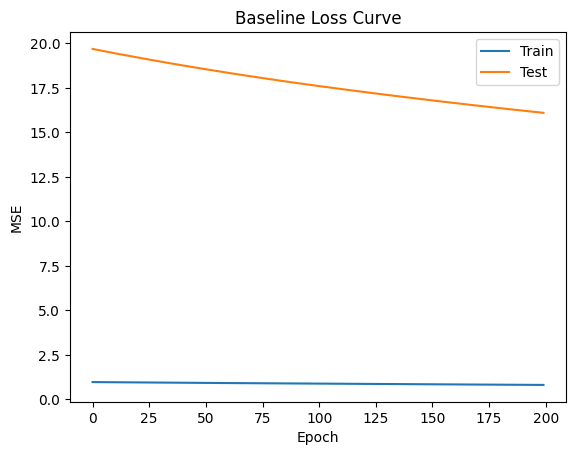

Baseline: MSE=16.094641, R²=-9.958097
Expected vs Predicted (first 3 samples):
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271

--- High LR ---
Starting training...
Architecture: 1 → 32 → 72 → 1
Learning Rate: 0.01
Max Epochs: 200, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss=0.821798, Test Loss=16.072238
Epoch  40: Train Loss=0.684958, Test Loss=13.913082
Epoch  60: Train Loss=0.555162, Test Loss=12.203833
Epoch  80: Train Loss=0.446341, Test Loss=10.800441
Epoch 100: Train Loss=0.350131, Test Loss=9.607271
Epoch 120: Train Loss=0.268709, Test Loss=8.556763
Epoch 140: Train Loss=0.202495, Test Loss=7.609130
Epoch 160: Train Loss=0.152585, Test Loss=6.775505
Epoch 180: Train Loss=0.115280, Test Loss=6.094829
Epoch 200: Train Loss=0.088181, Test Loss=5.545008


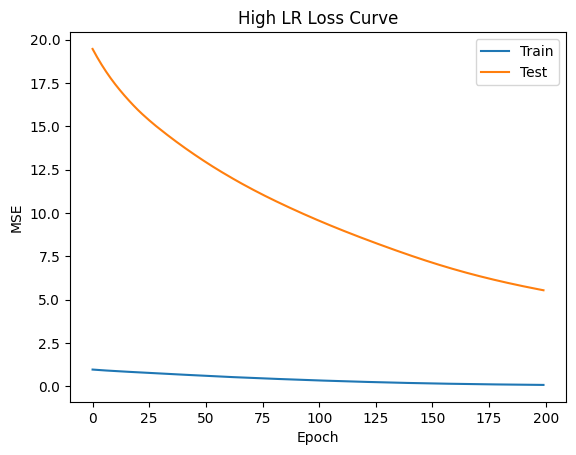

High LR: MSE=5.545008, R²=-2.775340
Expected vs Predicted (first 3 samples):
  Expected=2.236, Predicted=1.423
  Expected=2.236, Predicted=1.423
  Expected=2.236, Predicted=1.423

--- Large Batch ---
Starting training...
Architecture: 1 → 32 → 72 → 1
Learning Rate: 0.001
Max Epochs: 200, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss=0.955270, Test Loss=19.222920
Epoch  40: Train Loss=0.937128, Test Loss=18.774162
Epoch  60: Train Loss=0.920082, Test Loss=18.358340
Epoch  80: Train Loss=0.903897, Test Loss=17.971718
Epoch 100: Train Loss=0.888464, Test Loss=17.613191
Epoch 120: Train Loss=0.873165, Test Loss=17.278128
Epoch 140: Train Loss=0.857632, Test Loss=16.959866
Epoch 160: Train Loss=0.843036, Test Loss=16.656705
Epoch 180: Train Loss=0.828842, Test Loss=16.368717
Epoch 200: Train Loss=0.814833, Test Loss=16.094641


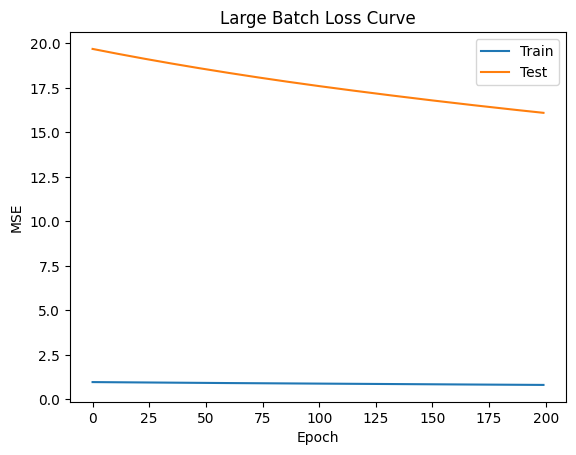

Large Batch: MSE=16.094641, R²=-9.958097
Expected vs Predicted (first 3 samples):
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271

--- Tanh Activation ---
Starting training...
Architecture: 1 → 32 → 72 → 1
Learning Rate: 0.001
Max Epochs: 200, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss=0.955270, Test Loss=19.222920
Epoch  40: Train Loss=0.937128, Test Loss=18.774162
Epoch  60: Train Loss=0.920082, Test Loss=18.358340
Epoch  80: Train Loss=0.903897, Test Loss=17.971718
Epoch 100: Train Loss=0.888464, Test Loss=17.613191
Epoch 120: Train Loss=0.873165, Test Loss=17.278128
Epoch 140: Train Loss=0.857632, Test Loss=16.959866
Epoch 160: Train Loss=0.843036, Test Loss=16.656705
Epoch 180: Train Loss=0.828842, Test Loss=16.368717
Epoch 200: Train Loss=0.814833, Test Loss=16.094641


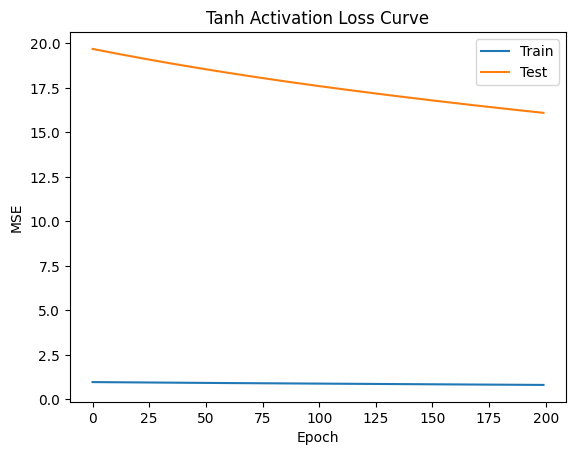

Tanh Activation: MSE=16.094641, R²=-9.958097
Expected vs Predicted (first 3 samples):
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271
  Expected=2.236, Predicted=0.271

--- More Epochs ---
Starting training...
Architecture: 1 → 32 → 72 → 1
Learning Rate: 0.001
Max Epochs: 500, Early Stopping Patience: 20
--------------------------------------------------
Epoch  20: Train Loss=0.955270, Test Loss=19.222920
Epoch  40: Train Loss=0.937128, Test Loss=18.774162
Epoch  60: Train Loss=0.920082, Test Loss=18.358340
Epoch  80: Train Loss=0.903897, Test Loss=17.971718
Epoch 100: Train Loss=0.888464, Test Loss=17.613191
Epoch 120: Train Loss=0.873165, Test Loss=17.278128
Epoch 140: Train Loss=0.857632, Test Loss=16.959866
Epoch 160: Train Loss=0.843036, Test Loss=16.656705
Epoch 180: Train Loss=0.828842, Test Loss=16.368717
Epoch 200: Train Loss=0.814833, Test Loss=16.094641
Epoch 220: Train Loss=0.800905, Test Loss=15.834365
Epoch 240: Train Loss=0.786960, Test Loss=15.592328

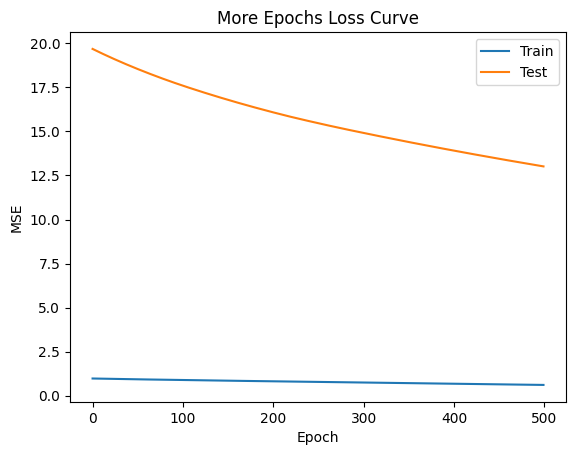

More Epochs: MSE=13.014711, R²=-7.861115
Expected vs Predicted (first 3 samples):
  Expected=2.236, Predicted=0.567
  Expected=2.236, Predicted=0.567
  Expected=2.236, Predicted=0.567


,Experiment,LR,Epochs,MSE,R2
0,Baseline,0.001,200,16.094641,-9.958097
1,High LR,0.010,200,5.545008,-2.775340
2,Large Batch,0.001,200,16.094641,-9.958097
3,Tanh Activation,0.001,200,16.094641,-9.958097
4,More Epochs,0.001,500,13.014711,-7.861115


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['LR'].plot(kind='hist', bins=20, title='LR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Epochs'].plot(kind='hist', bins=20, title='Epochs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Experiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='LR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='LR', y='Epochs', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Epochs', y='MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='MSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['LR']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Experiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Experiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('LR')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Experiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Experiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Experiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Experiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Experiment')):
  _plot_series(series, series_name, i)
  fig.legend(title='Experiment', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['LR'].plot(kind='line', figsize=(8, 4), title='LR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Epochs'].plot(kind='line', figsize=(8, 4), title='Epochs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Experiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Experiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Experiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='LR', y='Experiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Experiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Epochs', y='Experiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Experiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='MSE', y='Experiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [12]:
results=[]
results.append(run_experiment("Baseline",200,10,0.001,32,72))
results.append(run_experiment("High LR",200,10,0.01,32,72))
results.append(run_experiment("Large Batch",200,10,0.001,32,72))
results.append(run_experiment("Tanh Activation",200,10,0.001,32,72))
results.append(run_experiment("More Epochs",500,20,0.001,32,72))

pd.DataFrame(results)
